***
## Table of Contents
<br>
  <br>
    <ol>
        <h2><a href='#1' style="text-decoration : none; color : #000000;">1. Initial Models</a></h2>
        <ul>
            <a href='#1.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#1.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br> 

<ol>
        <h2><a href='#2' style="text-decoration : none; color : #000000;">2. Oversampling </a></h2>
        <ul>
            <a href='#2.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#2.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#3' style="text-decoration : none; color : #000000;">3. Undersampling</a></h2>
        <ul>
            <a href='#3.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#3.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
 <ol>
        <h2><a href='#4' style="text-decoration : none; color : #000000;">4.Feature Transformation with feature selection</a></h2>
        <ul>
            <a href='#4.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#4.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>
     
     
 <ol>
        <h2><a href='#5' style="text-decoration : none; color : #000000;">5.Feature Transformation with PCA</a></h2>
        <ul>
            <a href='#5.A' style="text-decoration : none; color : #000000;"><h3>A. Results </h3></a>
        </ul>
        <ul>
            <a href='#5.B' style="text-decoration : none; color : #000000;"><h3>B. Average Feature Importance   </h3></a>
        </ul>
     </ol>
     <br>

In [1]:
import pandas as pd
import numpy as np
import copy
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display,clear_output,HTML
import warnings
warnings.filterwarnings("ignore")

import keras
from keras.layers import Dense,Dropout
from keras.models import Sequential
warnings.simplefilter("ignore", DeprecationWarning)
import researchpy as rp

%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',305)

from sklearn.feature_selection import SelectKBest,chi2,RFE,RFECV,f_regression,SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn import metrics



from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,auc,roc_curve,recall_score,precision_score,matthews_corrcoef

from pandas_ml import ConfusionMatrix


from imblearn.over_sampling import SMOTE

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import featuretools as ft

from scipy import stats
import re

Using TensorFlow backend.


In [2]:
### Function to plot Feature Importance
def feat_impt_plot(feat_impt,y_labels,width_s=1000,height_s=1000):
    
    m=pd.DataFrame(y_labels,feat_impt).reset_index()
    m.columns=['Feature_Importance','Features']
    m.sort_values(by='Feature_Importance',inplace=True,ascending=False)
    m['Features']=m['Features'].str.replace("dom_function_","")
    m['Features']=m['Features'].str.replace("js_function_","")
    m['Features']=m['Features'].apply(lambda x: str(x).lstrip('.'))
    m['Features']=m['Features'].str.replace("(","")
    
    data = [go.Bar(x=m.Feature_Importance.values,y=m.Features.values,text=np.round(m.Feature_Importance,4),
            textposition = 'outside',
            marker=dict(
                color='rgb(158,202,225)',
                line=dict(
                    color='rgb(8,48,107)',
                    width=1.5),
            ),
            opacity=0.6,
            orientation='h'
        )]
    layout = go.Layout(autosize=False,
    width=width_s,
    height=height_s,
    xaxis=dict(title='Feature Importances',
        tickfont=dict(
            size=12,
            color='black'
        )),
    yaxis=dict(automargin=True))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig)

In [3]:
def uni_value(data):
    lst=[]
    for col in data.columns[:]:
        lst.append([col,dict(data[col].value_counts()),data[col].value_counts().values[0]>=len(data)*0.95])
    col_values=pd.DataFrame(lst,columns=['Feature','Value_Counts','95_%_same_values'])
    col_values.set_index('Feature',drop=True,inplace=True)
    del lst
    return col_values

    
def check_cat(data):
    cat_var=[]
    num_var=[]
    for col in data.columns:
        if col!='Target':
            if len(data[col].value_counts())==2:
                cat_var.append(col)
            else:
                num_var.append(col)
    return cat_var,num_var


def num_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        corr=stats.pointbiserialr(data[col],data.Target)[0]
        corr_p=stats.pointbiserialr(data[col],data.Target)[1]
        ttest=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[0]
        ttest_p=stats.ttest_ind(data[data.Target==1][col], data[data.Target==0][col], equal_var=False)[1]
        lst.append((corr,corr_p,ttest,ttest_p,col))
    stats_data=pd.DataFrame(lst,columns=['Pt. Biserial Corr','Pt. Biserial Corr p-val','ttest','ttest p-val','Feature'])
    stats_data.set_index('Feature',drop=True,inplace=True)
    stats_data.sort_values(by='ttest',inplace=True)
    del lst
    return stats_data


### Generate statistics for categorical data
def cat_stats(data,columns):
    lst=[]
    c=0
    for col in columns:
        if col!='Target':
            table, results = rp.crosstab(data['Target'], data[col], prop= 'col', test= 'chi-square')
            x=results['results'].values.tolist()
            x.append(col)
            lst.append(x)
    chi_df=pd.DataFrame(lst,columns=['Pearson Chi-square','p-value','Cramers V','Feature'])
    chi_df.set_index('Feature',drop=True,inplace=True)
    chi_df.sort_values(by='Cramers V',ascending=False,inplace=True)
    del lst
    return chi_df

def remove_feat(data):
    col_no_unique=[]
    for col in data.columns[:]:
        if len(data[col].value_counts())<=1:
#             print(col)
            col_no_unique.append(col)
    return col_no_unique

### Generate plot for class balance for categorical nature
def class_bal(data,title=''):
    d = [go.Bar(x=data.Target.value_counts().index.values,
               y=data.Target.value_counts().values,
               text=data.Target.value_counts().values,
               textposition = 'outside',
            )]
    layout = go.Layout(title=title,xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
    fig = go.Figure(data=d, layout=layout)
    iplot(fig)

In [4]:
def model_build(model,X_train,Y_train,X_test,Y_test,tree=False,feat=None):
    
    y_pred_train=model.predict(X_train)
    acc_train=accuracy_score(Y_train,y_pred_train)
    
    print("Accuracy of the model for training data is:",acc_train)
    print("Confusion Matrix for training data is:")
    cm_train=ConfusionMatrix(Y_train,y_pred_train)
    display(cm_train)
    
    
    y_pred_test=model.predict(X_test)
    acc_test=accuracy_score(Y_test,y_pred_test)
    print("Accuracy of the model for test data is:",acc_test)
    print("Confusion Matrix for test data is:")
    cm_test=ConfusionMatrix(Y_test,y_pred_test)
    display(cm_test)

    fpr, tpr, threshold = roc_curve(Y_test, y_pred_test)
    roc_auc =auc(fpr, tpr)
    mcc=matthews_corrcoef(Y_test,y_pred_test)
    if tree==True:
        feat_impt_plot(model.feature_importances_,feat)
        return model,cm_train,cm_test,acc_train,acc_test,roc_auc,model.feature_importances_,mcc
    
    return model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

def KNN_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'K-Nearest Neighbors' + '\033[0m')
    knn=KNeighborsClassifier()
    knn.fit(X_train,Y_train)

    return model_build(knn,X_train,Y_train,X_test,Y_test)

def Logistic_model(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Logistic Regression' + '\033[0m')
    log=LogisticRegression()
    log.fit(X_train,Y_train)
    
    return model_build(log,X_train,Y_train,X_test,Y_test)

def RandomForest(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'RandomForest Classifier' + '\033[0m')
    rf=RandomForestClassifier()
    rf.fit(X_train,Y_train)

    
    return model_build(rf,X_train,Y_train,X_test,Y_test,True,feat)

def AdaBoost(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'Adaoost Classifier' + '\033[0m')
    ada=AdaBoostClassifier()
    ada.fit(X_train,Y_train)
    
    return model_build(ada,X_train,Y_train,X_test,Y_test,True,feat)

def GradientBoosting(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'GradientBoosting Classifier' + '\033[0m')
    gbc=GradientBoostingClassifier()
    gbc.fit(X_train,Y_train)
    
    return model_build(gbc,X_train,Y_train,X_test,Y_test,True,feat)

def ExtraTree(X_train,Y_train,X_test,Y_test,feat):
    print('\033[1m' + 'ExtraTree Classifier' + '\033[0m')
    ext_tree=ExtraTreesClassifier()
    ext_tree.fit(X_train,Y_train)
    
    return model_build(ext_tree,X_train,Y_train,X_test,Y_test,True,feat)

def Bagging(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Bagging Classifier' + '\033[0m')
    bagging=BaggingClassifier()
    bagging.fit(X_train,Y_train)
    
    return model_build(bagging,X_train,Y_train,X_test,Y_test)

def DeepLearning1(X_train,Y_train,X_test,Y_test):
    print('\033[1m' + 'Neural Network-1' + '\033[0m')
    np.random.seed(0)
    deep_learning=Sequential()
    deep_learning.add(Dense(units=64,activation='relu',use_bias=True,kernel_initializer='uniform',input_dim=X_train.shape[1]))
    deep_learning.add(Dense(units=128,activation='relu',use_bias=True,kernel_initializer='uniform'))
    deep_learning.add(Dense(units=1,activation='sigmoid',use_bias=True,kernel_initializer='uniform'))
    deep_learning.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
    deep_learning.fit(X_train,Y_train,batch_size=20,epochs=80,verbose=False)
    acc_train=deep_learning.evaluate(X_train,Y_train,verbose=False)[1]
    print("The accuracy of the model on training data is:",acc_train)
    cm_train=ConfusionMatrix(Y_train,deep_learning.predict_classes(X_train,batch_size=1,verbose=False).reshape(1,len(X_train))[0])
    cm_test=ConfusionMatrix(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False).reshape(1,len(X_test))[0])
    display(cm_train)
    acc_test=accuracy_score(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    print("The accuracy of the model on test data is:",acc_test)
    display(cm_test)
    mcc=matthews_corrcoef(Y_test,deep_learning.predict_classes(X_test,batch_size=1,verbose=False))
    return  deep_learning,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc

In [5]:
df=pd.read_csv('URL.csv')

df.drop(['Unnamed: 0'],axis=1,inplace=True)

df.fillna(value=0,inplace=True)

cookies=[columns for columns in df.columns if 'number' in columns]

df.drop(cookies,axis=1,inplace=True)
df=df[df['domain']!=0]
df.sort_values(by='Target',inplace=True,ascending=False)

df.drop_duplicates(['domain'], keep='first',inplace=True)

df=df.sample(frac=1,random_state=0)
print("Shape of our dataset:",df.shape)

Shape of our dataset: (46771, 4195)


In [10]:
df['url_number_vowels'] = df['domain'].str.lower().str.count(r'[aeiou]')
df['url_number_consonants'] = df['domain'].str.count(r'[bcdfghjklmnpqrstvwxzy]', flags=re.I)
df['url_number_digits'] = df['domain'].str.count(r'\d')
df['url_number_special_chars']=df['url_length']-df[['url_number_vowels','url_number_consonants','url_number_digits']].sum(axis=1)
df.set_index(['domain'],inplace=True,drop=True)

In [11]:
df[['url_number_vowels','url_number_consonants','url_number_digits','url_number_special_chars','url_length']].head(10)

,url_number_vowels,url_number_consonants,url_number_digits,url_number_special_chars,url_length
domain,,,,,
tjk.org,1,5,0,1,7
magenta-musik-360.de,6,8,3,3,20
hitgelsin.com,4,8,0,1,13
80.82.77.17/bins-arm7,2,5,9,5,21
nu.edu.bd,3,4,0,2,9
allocine.fr,4,6,0,1,11
vsetop.org,3,6,0,1,10
ipko.pl,2,4,0,1,7
0594zs.com,1,4,4,1,10


In [12]:
df['url_port']=df['url_port'].apply(lambda x: 0 if x==0 else 1 )
df['url_number_vowels/url_length'] = df['url_number_vowels']/df['url_length']
df['url_number_consonants/url_length'] = df['url_number_consonants']/df['url_length']
df['url_number_digits/url_length'] = df['url_number_digits']/df['url_length']
df['url_number_special_chars/url_length']=df['url_number_special_chars']/df['url_length']

In [13]:
fin_col=['url_char_%',
 'url_char_&',
 'url_char_+',
 'url_char_-',
 'url_char_.',
 'url_char_/',
 'url_char_:',
 'url_char_=',
 'url_char_?',
 'url_char__',
 'url_port',
 'url_number_vowels/url_length',
 'url_number_consonants/url_length',
 'url_number_digits/url_length',
 'url_number_special_chars/url_length',
 'url_length',
 'url_tlds',
 'url_extensions',
 'url_number_digits',
 'url_number_consonants',
 'url_number_vowels',
 'url_number_special_chars',
 'Target']

In [14]:
df_sel=df[fin_col]

In [15]:
data = [go.Bar(x=df.Target.value_counts().index.values,
               y=df.Target.value_counts().values,
               text=df.Target.value_counts().values,
               textposition = 'outside',
            )]
layout = go.Layout( xaxis=dict(title='Domain Type',tickfont=dict(size=12,color='black')),
                    yaxis=dict(title='Number of Instances'))
fig = go.Figure(data=data, layout=layout)
iplot(fig)

In [16]:
train=df_sel.iloc[:37417,:]
train_X=train.iloc[:,train.columns!='Target'].values
train_Y=train.Target.values

scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=df_sel.iloc[37417:,:]
test_X=test.iloc[:,test.columns!='Target'].values
test_Y=test.Target.values
scaled_X_test=scaler.transform(test_X)

In [17]:
columns=fin_col

### <a id='1' style="text-decoration : none; color : #000000;"> 2. Initial Models</a>

In [18]:
columns.remove('Target')

In [19]:
ind_columns=['KNeighborsClassifier','LogisticRegression','RandomForestClassifier','AdaBoostClassifier',
             'GradientBoostingClassifier','ExtraTreeClassifier','BaggingClassifier','Neural Network-1']

f=[KNN_model,Logistic_model,RandomForest,AdaBoost,GradientBoosting, ExtraTree,Bagging,DeepLearning1]

## Table to store training and test measures
table_80_50_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_50_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','MCC'])

In [20]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_50_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_50_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.956623994441
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31383   509    31892
True        1114  4411     5525
__all__    32497  4920    37417

Accuracy of the model for test data is: 0.951464614069
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7834   151     7985
True         303  1066     1369
__all__     8137  1217     9354



Logistic Regression
Accuracy of the model for training data is: 0.938183178769
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31290   602    31892
True        1711  3814     5525
__all__    33001  4416    37417

Accuracy of the model for test data is: 0.935535599743
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7828   157     7985
True         446   923     1369
__all__     8274  1080     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.96400032071
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31537   355    31892
True         992  4533     5525
__all__    32529  4888    37417

Accuracy of the model for test data is: 0.950181740432
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7818   167     7985
True         299  1070     1369
__all__     8117  1237     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.935884758265
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31182   710    31892
True        1689  3836     5525
__all__    32871  4546    37417

Accuracy of the model for test data is: 0.931900791105
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7779   206     7985
True         431   938     1369
__all__     8210  1144     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.950343426785
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31295   597    31892
True        1261  4264     5525
__all__    32556  4861    37417

Accuracy of the model for test data is: 0.947295274749
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7815   170     7985
True         323  1046     1369
__all__     8138  1216     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.964615014566
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31593   299    31892
True        1025  4500     5525
__all__    32618  4799    37417

Accuracy of the model for test data is: 0.949861022023
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7834   151     7985
True         318  1051     1369
__all__     8152  1202     9354



Bagging Classifier
Accuracy of the model for training data is: 0.963759788332
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31499   393    31892
True         963  4562     5525
__all__    32462  4955    37417

Accuracy of the model for test data is: 0.949219585204
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7813   172     7985
True         303  1066     1369
__all__     8116  1238     9354



Neural Network-1
The accuracy of the model on training data is: 0.958040462894


Predicted  False  True  __all__
Actual                         
False      31474   418    31892
True        1152  4373     5525
__all__    32626  4791    37417

The accuracy of the model on test data is: 0.954244173616


Predicted  False  True  __all__
Actual                         
False       7863   122     7985
True         306  1063     1369
__all__     8169  1185     9354

### <a id='1.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [21]:
trace0 = go.Scatter(x=table_80_50_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_50_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_50_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_50_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_50_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_50_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_50_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_50_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_50_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [22]:
table_80_50_train['index']=ind_columns
table_80_50_test['index']=ind_columns


table_80_50_test.set_index(['index'],drop=True,inplace=True)
table_80_50_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_50_train)
print("Test Results")
display(table_80_50_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.956624,4411.0,31383.0,509.0,1114.0,0.015960,0.201629
LogisticRegression,0.938183,3814.0,31290.0,602.0,1711.0,0.018876,0.309683
RandomForestClassifier,0.964000,4533.0,31537.0,355.0,992.0,0.011131,0.179548
AdaBoostClassifier,0.935885,3836.0,31182.0,710.0,1689.0,0.022263,0.305701
GradientBoostingClassifier,0.950343,4264.0,31295.0,597.0,1261.0,0.018719,0.228235
ExtraTreeClassifier,0.964615,4500.0,31593.0,299.0,1025.0,0.009375,0.185520
BaggingClassifier,0.963760,4562.0,31499.0,393.0,963.0,0.012323,0.174299
Neural Network-1,0.958040,4373.0,31474.0,418.0,1152.0,0.013107,0.208507


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,MCC
index,,,,,,,,,
KNeighborsClassifier,0.951465,1066.0,7834.0,151.0,303.0,0.018910,0.221329,0.879880,0.798249
LogisticRegression,0.935536,923.0,7828.0,157.0,446.0,0.019662,0.325785,0.827276,0.723960
RandomForestClassifier,0.950182,1070.0,7818.0,167.0,299.0,0.020914,0.218408,0.880339,0.793702
AdaBoostClassifier,0.931901,938.0,7779.0,206.0,431.0,0.025798,0.314828,0.829687,0.711354
GradientBoostingClassifier,0.947295,1046.0,7815.0,170.0,323.0,0.021290,0.235939,0.871386,0.780672
ExtraTreeClassifier,0.949861,1051.0,7834.0,151.0,318.0,0.018910,0.232286,0.874402,0.790902
BaggingClassifier,0.949220,1066.0,7813.0,172.0,303.0,0.021540,0.221329,0.878565,0.789730
Neural Network-1,0.954244,1063.0,7863.0,122.0,306.0,0.015279,0.223521,0.878565,0.808900


### <a id='1.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [23]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='2' style="text-decoration : none; color : #000000;"> 2. OverSampling </a>

In [24]:
sm = SMOTE(random_state=12, ratio = 1.0)
X_train, Y_train = sm.fit_sample(scaled_X_train,train_Y)

/nethomes/darshan/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning:

Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.



In [25]:
## Table to store training and test measures so we can compare later
table_80_80_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_80_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [26]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_80_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_80_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.924071867553
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31143    749    31892
True        4094  27798    31892
__all__    35237  28547    63784

Accuracy of the model for test data is: 0.947722899294
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7753   232     7985
True         257  1112     1369
__all__     8010  1344     9354



Logistic Regression
Accuracy of the model for training data is: 0.879327103976
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29602   2290    31892
True        5407  26485    31892
__all__    35009  28775    63784

Accuracy of the model for test data is: 0.910840282232
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7382   603     7985
True         231  1138     1369
__all__     7613  1741     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.949626865672
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31186    706    31892
True        2507  29385    31892
__all__    33693  30091    63784

Accuracy of the model for test data is: 0.946867650203
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7732   253     7985
True         244  1125     1369
__all__     7976  1378     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.893766461809
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      29662   2230    31892
True        4546  27346    31892
__all__    34208  29576    63784

Accuracy of the model for test data is: 0.916613213598
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7409   576     7985
True         204  1165     1369
__all__     7613  1741     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.917737990719
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      30319   1573    31892
True        3674  28218    31892
__all__    33993  29791    63784

Accuracy of the model for test data is: 0.936070130425
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7575   410     7985
True         188  1181     1369
__all__     7763  1591     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.95009720306
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31244    648    31892
True        2535  29357    31892
__all__    33779  30005    63784

Accuracy of the model for test data is: 0.946226213385
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7733   252     7985
True         251  1118     1369
__all__     7984  1370     9354



Bagging Classifier
Accuracy of the model for training data is: 0.949454408629
Confusion Matrix for training data is:


Predicted  False   True  __all__
Actual                          
False      31154    738    31892
True        2486  29406    31892
__all__    33640  30144    63784

Accuracy of the model for test data is: 0.943232841565
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7718   267     7985
True         264  1105     1369
__all__     7982  1372     9354



Neural Network-1
The accuracy of the model on training data is: 0.921814248087


Predicted  False   True  __all__
Actual                          
False      30716   1176    31892
True        3811  28081    31892
__all__    34527  29257    63784

The accuracy of the model on test data is: 0.940667094291


Predicted  False  True  __all__
Actual                         
False       7625   360     7985
True         195  1174     1369
__all__     7820  1534     9354

### <a id='2.A' style="text-decoration : none; color : #000000;"> A Results</a>

In [27]:
trace0 = go.Scatter(x=table_80_80_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_80_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_80_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_80_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_80_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_80_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_80_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_80_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_80_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [28]:
table_80_80_train['index']=ind_columns
table_80_80_test['index']=ind_columns


table_80_80_test.set_index(['index'],drop=True,inplace=True)
table_80_80_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_80_train)
print("Test Results")
display(table_80_80_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.924072,27798.0,31143.0,749.0,4094.0,0.023486,0.128371
LogisticRegression,0.879327,26485.0,29602.0,2290.0,5407.0,0.071805,0.169541
RandomForestClassifier,0.949627,29385.0,31186.0,706.0,2507.0,0.022137,0.078609
AdaBoostClassifier,0.893766,27346.0,29662.0,2230.0,4546.0,0.069923,0.142544
GradientBoostingClassifier,0.917738,28218.0,30319.0,1573.0,3674.0,0.049323,0.115201
ExtraTreeClassifier,0.950097,29357.0,31244.0,648.0,2535.0,0.020319,0.079487
BaggingClassifier,0.949454,29406.0,31154.0,738.0,2486.0,0.023141,0.077951
Neural Network-1,0.921814,28081.0,30716.0,1176.0,3811.0,0.036874,0.119497


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.947723,1112.0,7753.0,232.0,257.0,0.029054,0.187728,0.891609,0.789234
LogisticRegression,0.910840,1138.0,7382.0,603.0,231.0,0.075517,0.168736,0.877874,0.686339
RandomForestClassifier,0.946868,1125.0,7732.0,253.0,244.0,0.031684,0.178232,0.895042,0.787943
AdaBoostClassifier,0.916613,1165.0,7409.0,576.0,204.0,0.072135,0.149014,0.889425,0.707320
GradientBoostingClassifier,0.936070,1181.0,7575.0,410.0,188.0,0.051346,0.137327,0.905664,0.763283
ExtraTreeClassifier,0.946226,1118.0,7733.0,252.0,251.0,0.031559,0.183346,0.892548,0.784858
BaggingClassifier,0.943233,1105.0,7718.0,267.0,264.0,0.033438,0.192841,0.886860,0.773020
Neural Network-1,0.940667,1174.0,7625.0,360.0,195.0,0.045085,0.142440,0.886860,0.775592


### <a id='2.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [29]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='3' style="text-decoration : none; color : #000000;"> 3. Undersampling</a>

In [30]:
df_non=train[train.Target==0]
df_mal=train[train.Target==1]

df_non=df_non.sample(frac=len(df_mal)/len(df_non),random_state=0)
df_u=df_non.append(df_mal)
df_u.Target.value_counts() 

X_train=df_u[columns]
X_train=scaler.transform(X_train)
Y_train=df_u.Target.values

print("Shape after undersampling",X_train.shape)


Shape after undersampling (11050, 22)


In [31]:
## Table to store training and test measures so we can compare later
table_80_90_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_90_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [32]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,scaled_X_test,test_Y,columns)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,scaled_X_test,test_Y)
    table_80_90_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_90_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.91257918552
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5321   204     5525
True         762  4763     5525
__all__     6083  4967    11050

Accuracy of the model for test data is: 0.935856318153
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7571   414     7985
True         186  1183     1369
__all__     7757  1597     9354



Logistic Regression
Accuracy of the model for training data is: 0.879004524887
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5102   423     5525
True         914  4611     5525
__all__     6016  5034    11050

Accuracy of the model for test data is: 0.910733376096
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7378   607     7985
True         228  1141     1369
__all__     7606  1748     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.928687782805
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5342   183     5525
True         605  4920     5525
__all__     5947  5103    11050

Accuracy of the model for test data is: 0.922493051101
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7443   542     7985
True         183  1186     1369
__all__     7626  1728     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.887239819005
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5111   414     5525
True         832  4693     5525
__all__     5943  5107    11050

Accuracy of the model for test data is: 0.909985033141
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7352   633     7985
True         209  1160     1369
__all__     7561  1793     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.90443438914
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5228   297     5525
True         759  4766     5525
__all__     5987  5063    11050

Accuracy of the model for test data is: 0.931045542014
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7516   469     7985
True         176  1193     1369
__all__     7692  1662     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.930769230769
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5397   128     5525
True         637  4888     5525
__all__     6034  5016    11050

Accuracy of the model for test data is: 0.926876202694
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7503   482     7985
True         202  1167     1369
__all__     7705  1649     9354



Bagging Classifier
Accuracy of the model for training data is: 0.929140271493
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False       5354   171     5525
True         612  4913     5525
__all__     5966  5084    11050

Accuracy of the model for test data is: 0.921103271328
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7436   549     7985
True         189  1180     1369
__all__     7625  1729     9354



Neural Network-1
The accuracy of the model on training data is: 0.915475113133


Predicted  False  True  __all__
Actual                         
False       5310   215     5525
True         719  4806     5525
__all__     6029  5021    11050

The accuracy of the model on test data is: 0.937566816335


Predicted  False  True  __all__
Actual                         
False       7581   404     7985
True         180  1189     1369
__all__     7761  1593     9354

### <a id='3.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [33]:
trace0 = go.Scatter(x=table_80_90_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_90_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_90_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_90_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_90_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_90_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_90_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_90_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_90_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [34]:
table_80_90_train['index']=ind_columns
table_80_90_test['index']=ind_columns


table_80_90_test.set_index(['index'],drop=True,inplace=True)
table_80_90_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_90_train)
print("Test Results")
display(table_80_90_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.912579,4763.0,5321.0,204.0,762.0,0.036923,0.137919
LogisticRegression,0.879005,4611.0,5102.0,423.0,914.0,0.076561,0.165430
RandomForestClassifier,0.928688,4920.0,5342.0,183.0,605.0,0.033122,0.109502
AdaBoostClassifier,0.887240,4693.0,5111.0,414.0,832.0,0.074932,0.150588
GradientBoostingClassifier,0.904434,4766.0,5228.0,297.0,759.0,0.053756,0.137376
ExtraTreeClassifier,0.930769,4888.0,5397.0,128.0,637.0,0.023167,0.115294
BaggingClassifier,0.929140,4913.0,5354.0,171.0,612.0,0.030950,0.110769
Neural Network-1,0.915475,4806.0,5310.0,215.0,719.0,0.038914,0.130136


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.935856,1183.0,7571.0,414.0,186.0,0.051847,0.135866,0.906144,0.763044
LogisticRegression,0.910733,1141.0,7378.0,607.0,228.0,0.076018,0.166545,0.878719,0.686811
RandomForestClassifier,0.922493,1186.0,7443.0,542.0,183.0,0.067877,0.133674,0.899224,0.727220
AdaBoostClassifier,0.909985,1160.0,7352.0,633.0,209.0,0.079274,0.152666,0.884030,0.689691
GradientBoostingClassifier,0.931046,1193.0,7516.0,469.0,176.0,0.058735,0.128561,0.906352,0.751513
ExtraTreeClassifier,0.926876,1167.0,7503.0,482.0,202.0,0.060363,0.147553,0.896042,0.734706
BaggingClassifier,0.921103,1180.0,7436.0,549.0,189.0,0.068754,0.138057,0.896595,0.722268
Neural Network-1,0.937567,1189.0,7581.0,404.0,180.0,0.050595,0.131483,0.896595,0.769103


### <a id='3.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [35]:
feat_impt_plot(np.average(feat_imp,axis=0),columns)

### <a id='4' style="text-decoration : none; color : #000000;">4. Feature Transformation with feature selection </a>

In [36]:
df.reset_index(inplace=True)

# columns=columns.tolist()
columns.append('domain')

df_min=df[columns]

In [37]:
es = ft.EntitySet(id = 'malicious')
es.entity_from_dataframe(entity_id = 'data', dataframe = df_min, index = 'domain')

feature_matrix_sessions, features_defs = ft.dfs(entityset=es,target_entity="data",
                                                trans_primitives = ['add','divide','multiply'],n_jobs=-1,
                                                verbose=1,max_depth=1)

Built 946 features
EntitySet scattered to workers in 4.576 seconds
Elapsed: 00:05 | Remaining: 00:00 | Progress: 100%|██████████| Calculated: 11/11 chunks


In [38]:
df.set_index(['domain'],drop=True,inplace=True)
fs=pd.merge(feature_matrix_sessions,pd.DataFrame(df.Target),left_index=True, right_index=True)
fs.replace([np.inf],0,inplace=True)
fs.fillna(value=0,inplace=True)

In [39]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target
feature_name = X.columns.tolist()

In [40]:
def cor_selector(X, y):
    cor_list = []
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-100:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature


cor_support, cor_feature = cor_selector(X, y)

In [41]:
X_norm = MinMaxScaler().fit_transform(X)
chi_selector = SelectKBest(chi2, k=100)
chi_selector.fit(X_norm, y)
chi_support = chi_selector.get_support()
chi_feature = X.loc[:,chi_support].columns.tolist()

In [42]:
rfe_selector = RFE(estimator=LogisticRegression(random_state=0), n_features_to_select=100, step=0.3, verbose=False)
rfe_selector.fit(X_norm, y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

In [43]:
embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100,random_state=0), threshold='23*median')
embeded_rf_selector.fit(X, y)
embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()

In [44]:
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support,
                                    'Random Forest':embeded_rf_support})
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)

In [47]:
X=fs[feature_selection_df[feature_selection_df.Total>=3]['Feature']]
X.fillna(value=0,inplace=True)
y=fs.Target.values
feature_name = X.columns.tolist()

scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

print("The train/test split ratio is 80:20")
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X,y,random_state=0,test_size=0.2)

X.shape

The train/test split ratio is 80:20


(46771, 29)

In [48]:
print('Features we will be using:\n')
display(feature_name)

Features we will be using:



['url_number_consonants/url_length / url_number_special_chars',
 'url_number_vowels/url_length / url_number_vowels',
 'url_number_vowels/url_length / url_number_special_chars',
 'url_number_vowels/url_length / url_char_/',
 'url_number_special_chars/url_length / url_char_/',
 'url_number_digits/url_length + url_number_special_chars',
 'url_number_consonants/url_length / url_char_/',
 'url_extensions / url_number_vowels/url_length',
 'url_extensions + url_port',
 'url_extensions + url_number_vowels/url_length',
 'url_extensions + url_number_consonants/url_length',
 'url_extensions * url_number_consonants/url_length',
 'url_char_= + url_extensions',
 'url_char_: + url_extensions',
 'url_char_/ / url_number_special_chars',
 'url_char_/ / url_length',
 'url_char_/ / url_extensions',
 'url_char_/ + url_extensions',
 'url_char_. + url_port',
 'url_char_. + url_number_special_chars/url_length',
 'url_char_. + url_number_digits/url_length',
 'url_char_. + url_char__',
 'url_char_. + url_char_:

In [49]:
fs=fs.reindex(df_sel.index.values)

In [50]:
train=fs.iloc[:37417]
train_Y=train.Target.values
train_X=train[feature_name].values


scaler=StandardScaler()
scaled_X_train=scaler.fit_transform(train_X)

test=fs.iloc[37417:]
test_Y=test.Target.values
test_X=test[feature_name]

scaled_X_test=scaler.transform(test_X)

In [51]:
## Table to store training and test measures so we can compare later
table_80_60_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_60_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [52]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y,feature_name)
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](scaled_X_train,train_Y,scaled_X_test,test_Y)
    table_80_60_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_60_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.949915813668
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31260   632    31892
True        1242  4283     5525
__all__    32502  4915    37417

Accuracy of the model for test data is: 0.942377592474
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7792   193     7985
True         346  1023     1369
__all__     8138  1216     9354



Logistic Regression
Accuracy of the model for training data is: 0.936446000481
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31251   641    31892
True        1737  3788     5525
__all__    32988  4429    37417

Accuracy of the model for test data is: 0.934573444516
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7819   166     7985
True         446   923     1369
__all__     8265  1089     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.956436913702
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31348   544    31892
True        1086  4439     5525
__all__    32434  4983    37417

Accuracy of the model for test data is: 0.944088090656
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7790   195     7985
True         328  1041     1369
__all__     8118  1236     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.939626373039
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31299   593    31892
True        1666  3859     5525
__all__    32965  4452    37417

Accuracy of the model for test data is: 0.937032285653
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7819   166     7985
True         423   946     1369
__all__     8242  1112     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.947911377181
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31206   686    31892
True        1263  4262     5525
__all__    32469  4948    37417

Accuracy of the model for test data is: 0.944836433611
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7793   192     7985
True         324  1045     1369
__all__     8117  1237     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.956864526819
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31422   470    31892
True        1144  4381     5525
__all__    32566  4851    37417

Accuracy of the model for test data is: 0.944301902929
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7815   170     7985
True         351  1018     1369
__all__     8166  1188     9354



Bagging Classifier
Accuracy of the model for training data is: 0.956410187883
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31358   534    31892
True        1097  4428     5525
__all__    32455  4962    37417

Accuracy of the model for test data is: 0.943019029292
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7789   196     7985
True         337  1032     1369
__all__     8126  1228     9354



Neural Network-1
The accuracy of the model on training data is: 0.950503781705


Predicted  False  True  __all__
Actual                         
False      31212   680    31892
True        1172  4353     5525
__all__    32384  5033    37417

The accuracy of the model on test data is: 0.947295274749


Predicted  False  True  __all__
Actual                         
False       7799   186     7985
True         307  1062     1369
__all__     8106  1248     9354

### <a id='4.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [53]:
trace0 = go.Scatter(x=table_80_60_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_60_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_60_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_60_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_60_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_60_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_60_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_60_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_60_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [54]:
table_80_60_train['index']=ind_columns
table_80_60_test['index']=ind_columns


table_80_60_test.set_index(['index'],drop=True,inplace=True)
table_80_60_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_60_train)
print("Test Results")
display(table_80_60_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.949916,4283.0,31260.0,632.0,1242.0,0.019817,0.224796
LogisticRegression,0.936446,3788.0,31251.0,641.0,1737.0,0.020099,0.314389
RandomForestClassifier,0.956437,4439.0,31348.0,544.0,1086.0,0.017058,0.196561
AdaBoostClassifier,0.939626,3859.0,31299.0,593.0,1666.0,0.018594,0.301538
GradientBoostingClassifier,0.947911,4262.0,31206.0,686.0,1263.0,0.021510,0.228597
ExtraTreeClassifier,0.956865,4381.0,31422.0,470.0,1144.0,0.014737,0.207059
BaggingClassifier,0.956410,4428.0,31358.0,534.0,1097.0,0.016744,0.198552
Neural Network-1,0.950504,4353.0,31212.0,680.0,1172.0,0.021322,0.212127


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.942378,1023.0,7792.0,193.0,346.0,0.024170,0.252739,0.861545,0.759987
LogisticRegression,0.934573,923.0,7819.0,166.0,446.0,0.020789,0.325785,0.826713,0.720112
RandomForestClassifier,0.944088,1041.0,7790.0,195.0,328.0,0.024421,0.239591,0.867994,0.768204
AdaBoostClassifier,0.937032,946.0,7819.0,166.0,423.0,0.020789,0.308985,0.835113,0.731968
GradientBoostingClassifier,0.944836,1045.0,7793.0,192.0,324.0,0.024045,0.236669,0.869643,0.771381
ExtraTreeClassifier,0.944302,1018.0,7815.0,170.0,351.0,0.021290,0.256392,0.861159,0.766752
BaggingClassifier,0.943019,1032.0,7789.0,196.0,337.0,0.024546,0.246165,0.864644,0.763310
Neural Network-1,0.947295,1062.0,7799.0,186.0,307.0,0.023294,0.224251,0.864644,0.782184


### <a id='4.B' style="text-decoration : none; color : #000000;"> B. Average Feature Importances</a>

In [55]:
feat_impt_plot(np.average(feat_imp,axis=0),feature_name)

### <a id='5' style="text-decoration : none; color : #000000;">5. Feature Transformation with PCA </a>

In [56]:
X=fs.loc[:,fs.columns!='Target']
y=fs.Target.values
feature_name = X.columns.tolist()
X=np.nan_to_num(X)
scaler=StandardScaler()
scaled_X=scaler.fit_transform(X)

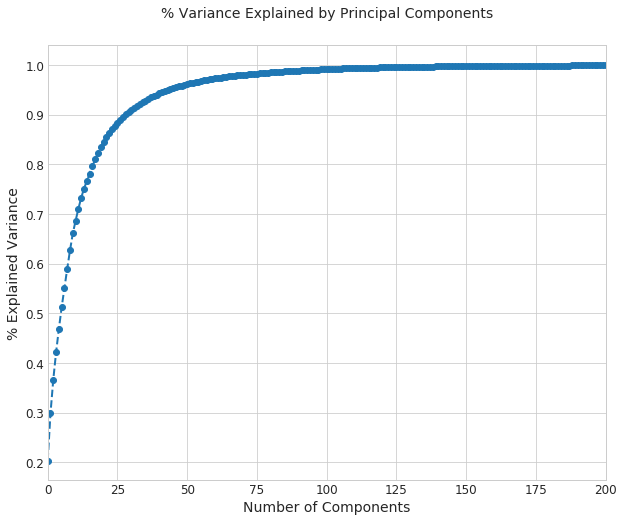

In [57]:
sns.set_style('whitegrid')
pca = PCA(random_state=0)
pca.fit(scaled_X)
plt.figure(1, figsize=(10, 8))
plt.plot(np.cumsum(pca.explained_variance_ratio_),'--o', linewidth=2)
plt.axis('tight')
plt.xlabel('Number of Components',size=14)
plt.xticks(size=12)
plt.xlim([0,200])
plt.ylabel('% Explained Variance',size=14)
plt.yticks(size=12)
plt.title('% Variance Explained by Principal Components',size=14,y=1.05)
plt.show()

In [59]:
pca=PCA(n_components=27,whiten=True,random_state=0)
X_pca_21=pca.fit_transform(scaled_X)
print("Variance explained using 27 components is:",sum(pca.explained_variance_ratio_))

Variance explained using 27 components is: 0.89039818179


In [60]:
X_train=X_pca_21[:37417]
Y_train=fs.iloc[:37417]['Target'].values
X_test=X_pca_21[37417:]
Y_test=fs.iloc[37417:]['Target'].values

## Table to store training and test measures so we can compare later
table_80_70_train=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR'])
table_80_70_test=pd.DataFrame(columns=['accuracy','TP','TN','FP','FN','FPR','FNR','auc','mcc'])

In [61]:
feat_imp=[None]*4
j=0
for i in range(0,8):
    if i>=2 and i<=5:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,feat_imp[j],mcc=f[i](X_train,Y_train,X_test,Y_test,np.arange(0,27).astype(str))
        j=j+1
    else:
        model,cm_train,cm_test,acc_train,acc_test,roc_auc,mcc=f[i](X_train,Y_train,X_test,Y_test)
    table_80_70_train.loc[i]=   ([acc_train,cm_train.TP,cm_train.TN,cm_train.FP,cm_train.FN,cm_train.FPR,cm_train.FNR])
    table_80_70_test.loc[i] =   ([acc_test ,cm_test.TP, cm_test.TN, cm_test.FP, cm_test.FN, cm_test.FPR, cm_test.FNR,roc_auc,mcc])
    print("\n")

K-Nearest Neighbors
Accuracy of the model for training data is: 0.957024881738
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31404   488    31892
True        1120  4405     5525
__all__    32524  4893    37417

Accuracy of the model for test data is: 0.951999144751
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7835   150     7985
True         299  1070     1369
__all__     8134  1220     9354



Logistic Regression
Accuracy of the model for training data is: 0.93807627549
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31333   559    31892
True        1758  3767     5525
__all__    33091  4326    37417

Accuracy of the model for test data is: 0.935749412016
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7839   146     7985
True         455   914     1369
__all__     8294  1060     9354



RandomForest Classifier
Accuracy of the model for training data is: 0.96400032071
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31511   381    31892
True         966  4559     5525
__all__    32477  4940    37417

Accuracy of the model for test data is: 0.954244173616
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7839   146     7985
True         282  1087     1369
__all__     8121  1233     9354



Adaoost Classifier
Accuracy of the model for training data is: 0.942806745597
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31313   579    31892
True        1561  3964     5525
__all__    32874  4543    37417

Accuracy of the model for test data is: 0.941094718837
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7826   159     7985
True         392   977     1369
__all__     8218  1136     9354



GradientBoosting Classifier
Accuracy of the model for training data is: 0.953630702622
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31356   536    31892
True        1199  4326     5525
__all__    32555  4862    37417

Accuracy of the model for test data is: 0.950930083387
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7844   141     7985
True         318  1051     1369
__all__     8162  1192     9354



ExtraTree Classifier
Accuracy of the model for training data is: 0.964615014566
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31593   299    31892
True        1025  4500     5525
__all__    32618  4799    37417

Accuracy of the model for test data is: 0.950716271114
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7843   142     7985
True         319  1050     1369
__all__     8162  1192     9354



Bagging Classifier
Accuracy of the model for training data is: 0.96392014325
Confusion Matrix for training data is:


Predicted  False  True  __all__
Actual                         
False      31538   354    31892
True         996  4529     5525
__all__    32534  4883    37417

Accuracy of the model for test data is: 0.951785332478
Confusion Matrix for test data is:


Predicted  False  True  __all__
Actual                         
False       7837   148     7985
True         303  1066     1369
__all__     8140  1214     9354



Neural Network-1
The accuracy of the model on training data is: 0.958868963309


Predicted  False  True  __all__
Actual                         
False      31505   387    31892
True        1152  4373     5525
__all__    32657  4760    37417

The accuracy of the model on test data is: 0.953709642934


Predicted  False  True  __all__
Actual                         
False       7864   121     7985
True         312  1057     1369
__all__     8176  1178     9354

### <a id='5.A' style="text-decoration : none; color : #000000;"> A. Results</a>

In [62]:
trace0 = go.Scatter(x=table_80_70_test.iloc[0].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[0].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'KNN_model')

trace1 = go.Scatter(x=table_80_70_test.iloc[1].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[1].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'Logistic Regression')

trace2 = go.Scatter(x=table_80_70_test.iloc[2].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[2].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Random Forest')


trace3 = go.Scatter(x=table_80_70_test.iloc[3].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[3].values[[0,5,6,7]],
                    mode = 'lines',
                    name = 'Ada Boost')

trace4 = go.Scatter(x=table_80_70_test.iloc[4].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[4].values[[0,5,6,7]],
                    mode = 'lines+markers',
                    name = 'GradientBoosting')

trace5 = go.Scatter(x=table_80_70_test.iloc[5].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[5].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'ExtraTree Classifier')

trace6 = go.Scatter(x=table_80_70_test.iloc[6].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[6].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Bagging')

trace7 = go.Scatter(x=table_80_70_test.iloc[7].index.values[[0,5,6,7]],
                    y=table_80_70_test.iloc[7].values[[0,5,6,7]],
                    mode = 'lines+markers',marker=dict(symbol='x'),
                    name = 'Neural Network')



data = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
layout = go.Layout(yaxis=dict(tick0=0,dtick=0.05),title='Result comparision for Features selected in Section 1')
fig = go.Figure(data=data, layout=layout)

iplot(fig, filename='Result')

In [63]:
table_80_70_train['index']=ind_columns
table_80_70_test['index']=ind_columns


table_80_70_test.set_index(['index'],drop=True,inplace=True)
table_80_70_train.set_index(['index'],drop=True,inplace=True)

print("Training Results")
display(table_80_70_train)
print("Test Results")
display(table_80_70_test)

Training Results


,accuracy,TP,TN,FP,FN,FPR,FNR
index,,,,,,,
KNeighborsClassifier,0.957025,4405.0,31404.0,488.0,1120.0,0.015302,0.202715
LogisticRegression,0.938076,3767.0,31333.0,559.0,1758.0,0.017528,0.318190
RandomForestClassifier,0.964000,4559.0,31511.0,381.0,966.0,0.011947,0.174842
AdaBoostClassifier,0.942807,3964.0,31313.0,579.0,1561.0,0.018155,0.282534
GradientBoostingClassifier,0.953631,4326.0,31356.0,536.0,1199.0,0.016807,0.217014
ExtraTreeClassifier,0.964615,4500.0,31593.0,299.0,1025.0,0.009375,0.185520
BaggingClassifier,0.963920,4529.0,31538.0,354.0,996.0,0.011100,0.180271
Neural Network-1,0.958869,4373.0,31505.0,387.0,1152.0,0.012135,0.208507


Test Results


,accuracy,TP,TN,FP,FN,FPR,FNR,auc,mcc
index,,,,,,,,,
KNeighborsClassifier,0.951999,1070.0,7835.0,150.0,299.0,0.018785,0.218408,0.881404,0.800612
LogisticRegression,0.935749,914.0,7839.0,146.0,455.0,0.018284,0.332359,0.824678,0.724081
RandomForestClassifier,0.954244,1087.0,7839.0,146.0,282.0,0.018284,0.205990,0.887863,0.810515
AdaBoostClassifier,0.941095,977.0,7826.0,159.0,392.0,0.019912,0.286340,0.846874,0.750703
GradientBoostingClassifier,0.950930,1051.0,7844.0,141.0,318.0,0.017658,0.232286,0.875028,0.795053
ExtraTreeClassifier,0.950716,1050.0,7843.0,142.0,319.0,0.017783,0.233017,0.874600,0.794146
BaggingClassifier,0.951785,1066.0,7837.0,148.0,303.0,0.018535,0.221329,0.880068,0.799482
Neural Network-1,0.953710,1057.0,7864.0,121.0,312.0,0.015153,0.227904,0.880068,0.806416


In [64]:
### Original Creator : Darshan Bhansali
### HTML code to hide the input cells 
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
To toggle code, click <a href="javascript:code_toggle()">here</a>.''')